# Assignment 2 - Task 2: Offering Strategy for stochastic assets in ancillary service markets

#### Imports

In [ ]:
import numpy as np
import pandas as pd
import random

from gurobipy import Model, GRB, quicksum
aimport time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


### Introduction to the Tasks Based on Lecture 10
In Lecture 10, we explore the offering strategy for stochastic assets in ancillary service markets.
Specifically, we consider a price-taking stochastic flexible load, which can either be a large energy
consumer or an aggregator of small-scale loads, such as electric vehicles. This flexible load has
a range of energy consumption from 0 kW to 600 kW. For simplicity, we focus on the FCR-D
UP market in DK2 with hourly bids, where the flexible load seeks to sell its flexibility. The load
can offer this service due to its ability to quickly adjust its consumption level. Importantly, we
3
assume there is no minimum bid size requirement. To keep the analysis manageable, we consider
a single hour for bidding with minute-level resolution for the flexible load’s consumption

### Data Generation for Future Stochastic Load: 
Randomly generate 300 consumption load profiles, ensuring that for each profile, the load at every minute falls between 220 kW and 600
kW. Additionally, the change in consumption between two consecutive minutes must not exceed
35 kW. These limits are set for the stochastic data generation process and do not represent
technical constraints. Out of these 300 profiles, 100 will be used for in-sample decision-making
(i.e., reserve capacity bidding to the FCR-D UP market in kW), while the remaining 200 will be
designated for out-of-sample analysis. Each in-sample profile will have an equal probability.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_profiles = 300
minutes_per_profile = 60
min_power = 220  # kW
max_power = 600  # kW
max_delta = 35   # kW (max allowed change between consecutive minutes)

# Function to generate a single valid profile
def generate_profile():
    profile = [np.random.uniform(min_power, max_power)]
    for _ in range(minutes_per_profile - 1):
        # Define min and max next value respecting the max_delta constraint
        lower_bound = max(min_power, profile[-1] - max_delta)
        upper_bound = min(max_power, profile[-1] + max_delta)
        next_value = round(np.random.uniform(lower_bound, upper_bound),2)
        profile.append(next_value)
    return profile

# Generate all profiles
profiles = []
while len(profiles) < num_profiles:
    profile = generate_profile()
    profiles.append(profile)

# Convert to DataFrame
profiles_df = pd.DataFrame(profiles)
profiles_df.index.name = 'Profile'
profiles_df.columns = [i for i in range(minutes_per_profile)]

# Split into in-sample (100) and out-of-sample (200)
in_sample_profiles = profiles_df.sample(n=100, random_state=42)
out_of_sample_profiles = profiles_df.drop(in_sample_profiles.index)

# Display basic info
print(f"In-sample profiles: {in_sample_profiles.shape}")
print(f"Out-of-sample profiles: {out_of_sample_profiles.shape}")

# Save to CSV for later use
in_sample_profiles.to_csv('data/in_sample_profiles.csv')
out_of_sample_profiles.to_csv('data/out_of_sample_profiles.csv')

In-sample profiles: (100, 60)
Out-of-sample profiles: (200, 60)


In [3]:
in_sample_profiles

0       1       2       3       4       5       6       7   \
Profile                                                                       
203      325.610364  352.93  356.43  350.37  320.46  335.45  349.65  357.63   
266      431.092794  451.49  456.66  440.23  451.96  442.26  445.40  444.53   
152      557.869604  555.62  566.64  592.83  574.40  597.68  578.20  577.34   
9        582.539390  579.34  557.07  569.09  574.83  561.38  534.33  546.34   
233      263.023847  287.01  270.11  255.04  287.24  278.78  244.45  236.87   
...             ...     ...     ...     ...     ...     ...     ...     ...   
16       251.463494  260.09  242.26  242.29  236.54  238.33  258.35  244.15   
179      282.852344  302.25  283.28  285.14  281.75  287.32  313.72  339.46   
147      251.872021  286.39  260.29  230.35  259.84  245.97  259.65  247.68   
274      370.044396  352.88  328.86  342.34  313.86  344.51  367.38  392.41   
67       376.295509  358.13  370.20  393.02  405.14  427.84  420.63  396.57   

             8       9   ...      50      51      52      53      54      55  \
Profile                  ...                                                   
203      358.35  353.71  ...  253.31  286.75  259.54  239.39  245.73  278.82   
266      436.21  451.53  ...  433.06  421.52  413.92  448.21  427.76  430.89   
152      583.27  597.44  ...  518.57  543.45  510.68  481.01  465.18  444.17   
9        547.76  566.82  ...  415.74  425.60  403.33  392.53  420.31  418.49   
233      226.19  224.23  ...  247.24  270.71  297.88  280.02  285.23  304.02   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
16       253.50  252.61  ...  341.99  376.13  407.21  374.97  389.36  419.13   
179      336.04  302.12  ...  287.61  276.34  298.69  272.84  249.98  242.15   
147      244.54  235.61  ...  319.31  293.69  305.70  271.01  300.74  273.62   
274      420.88  414.48  ...  278.17  254.77  247.57  239.79  225.32  237.44   
67       413.23  403.46  ...  569.27  578.74  577.17  577.05  581.60  577.32   

             56      57      58      59  
Profile                                  
203      297.85  325.73  314.09  348.53  
266      465.00  485.44  519.98  552.76  
152      425.40  446.26  450.68  416.08  
9        430.22  407.28  385.74  353.60  
233      289.24  282.87  284.55  258.99  
...         ...     ...     ...     ...  
16       396.77  401.53  430.61  397.99  
179      243.35  240.35  262.27  234.06  
147      245.26  240.07  240.57  231.91  
274      237.73  226.47  232.28  261.91  
67       567.07  550.81  569.61  549.41  

[100 rows x 60 columns]

In [4]:
out_of_sample_profiles

0       1       2       3       4       5       6       7   \
Profile                                                                       
0        362.325245  393.88  410.12  417.03  392.95  368.87  337.94  363.57   
1        367.697370  351.69  374.70  364.67  349.34  352.33  327.19  348.34   
2        526.827259  554.55  541.81  514.51  495.47  490.37  512.63  537.88   
3        349.605213  322.55  352.28  378.69  361.75  372.95  395.16  399.02   
4        577.374262  597.35  596.79  575.93  541.84  571.82  563.87  596.54   
...             ...     ...     ...     ...     ...     ...     ...     ...   
293      410.443319  401.27  373.66  389.92  377.39  360.96  371.62  375.75   
294      325.916263  327.50  316.65  288.99  321.07  345.90  316.39  331.78   
296      463.478677  485.42  474.88  481.55  458.50  445.30  411.72  430.50   
298      330.667145  352.19  350.89  361.73  339.98  342.33  329.59  331.44   
299      464.883588  455.91  464.17  469.45  462.05  448.52  442.01  447.18   

             8       9   ...      50      51      52      53      54      55  \
Profile                  ...                                                   
0        370.65  385.22  ...  266.77  286.03  316.79  344.43  351.28  380.81   
1        318.56  352.64  ...  236.40  228.29  260.25  281.82  291.16  317.16   
2        503.37  504.12  ...  400.33  366.49  367.34  348.19  358.35  335.56   
3        401.10  383.03  ...  442.71  442.89  448.27  447.75  426.42  441.99   
4        598.60  594.65  ...  465.34  432.95  455.53  445.74  419.63  421.19   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
293      366.12  376.02  ...  376.14  375.92  373.25  383.02  379.92  376.96   
294      321.11  355.75  ...  420.58  405.73  434.15  424.34  393.75  400.79   
296      423.57  445.70  ...  428.43  404.80  374.31  358.15  365.64  339.26   
298      351.10  369.92  ...  328.28  329.48  334.53  308.62  332.47  352.56   
299      442.15  425.60  ...  330.44  356.40  322.68  325.85  341.80  350.33   

             56      57      58      59  
Profile                                  
0        352.00  330.72  298.89  286.66  
1        338.42  316.48  343.96  346.71  
2        348.93  341.00  371.57  346.20  
3        426.64  393.34  403.52  380.92  
4        440.09  420.20  428.80  399.77  
...         ...     ...     ...     ...  
293      343.10  320.28  319.48  342.07  
294      374.53  395.29  405.21  431.44  
296      337.27  346.18  370.59  351.68  
298      363.51  361.14  393.65  420.18  
299      368.57  384.37  397.81  420.32  

[200 rows x 60 columns]

#### Check created profiles

In [5]:
def check_profiles(df, min_power=220, max_power=600, max_delta=35):
    """
    Checks if all profiles in the dataframe satisfy:
    - Power between min_power and max_power at all times.
    - Change between consecutive minutes does not exceed max_delta.
    """
    # Check min/max values
    within_bounds = df.map(lambda x: min_power <= x <= max_power).all().all()
    
    # Check max delta between consecutive minutes
    diffs = df.diff(axis=1).iloc[:, 1:]  # calculate minute-to-minute differences
    within_deltas = diffs.map(lambda x: abs(x) <= max_delta).all().all()
    
    if within_bounds and within_deltas:
        print("✅ All profiles satisfy the requirements.")
    else:
        print("❌ Some profiles violate the requirements.")
    
    return within_bounds, within_deltas

# Example usage
check_profiles(in_sample_profiles)
check_profiles(out_of_sample_profiles)

✅ All profiles satisfy the requirements.
✅ All profiles satisfy the requirements.


(True, True)

#### Short Analysis of created profiles

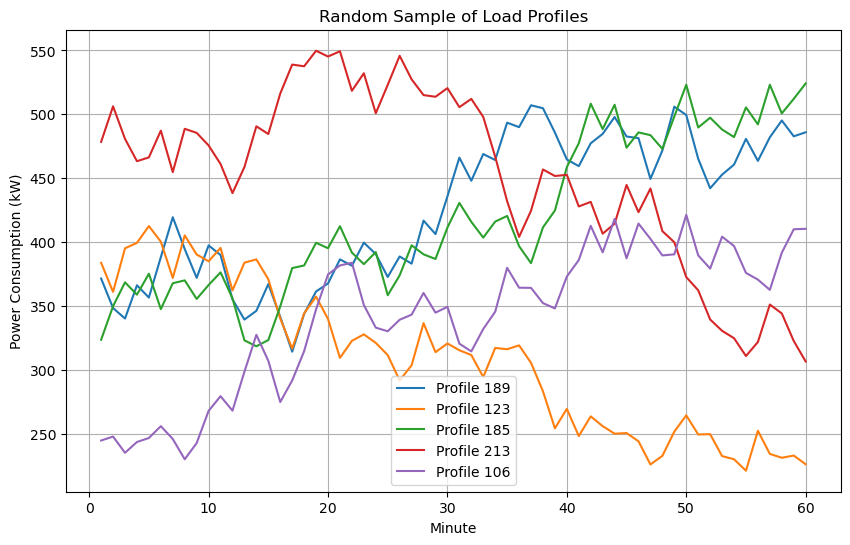

In [ ]:
# 1. Plot a few random profiles
def plot_random_profiles(df, num_profiles=5):
    plt.figure(figsize=(10,6))
    sample = df.sample(num_profiles, random_state=1)
    for idx, row in sample.iterrows():
        plt.plot(range(1, 61), row.values, label=f'Profile {idx}')
    plt.xlabel('Minute')
    plt.ylabel('Power Consumption (kW)')
    plt.title('Random Sample of Load Profiles')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Plot histogram of all power values
def plot_power_distribution(df):
    plt.figure(figsize=(8,5))
    plt.hist(df.values.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('Power Consumption (kW)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Power Values Across All Profiles')
    plt.grid(True)
    plt.show()

# 3. Plot histogram of minute-to-minute deltas
def plot_delta_distribution(df):
    deltas = df.diff(axis=1).iloc[:, 1:].values.flatten()
    plt.figure(figsize=(8,5))
    plt.hist(deltas, bins=50, color='lightgreen', edgecolor='black')
    plt.xlabel('Minute-to-Minute Delta (kW)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Minute-to-Minute Changes')
    plt.grid(True)
    plt.show()

# Example usage:
plot_random_profiles(profiles_df)

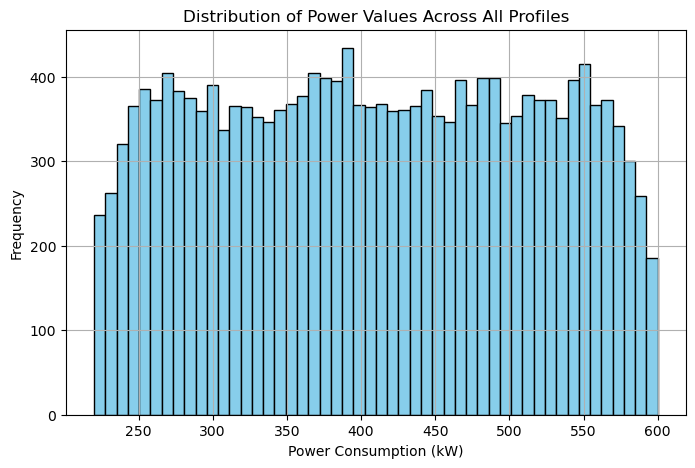

In [7]:
plot_power_distribution(profiles_df)

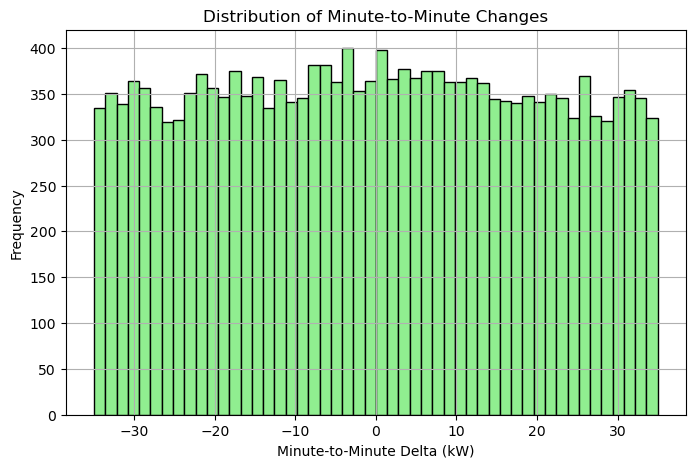

In [8]:
plot_delta_distribution(profiles_df)

### 2.1 In-sample Decision Making: Offering Strategy Under the P90 Requirement:
Given the P90 requirement of Energinet, determine the optimal reserve capacity bid (in
kW) of the stochastic load in the FCR-D UP market for the given hour. Utilize both
ALSO-X and CVaR techniques to solve this problem, as these methods may yield different
results.

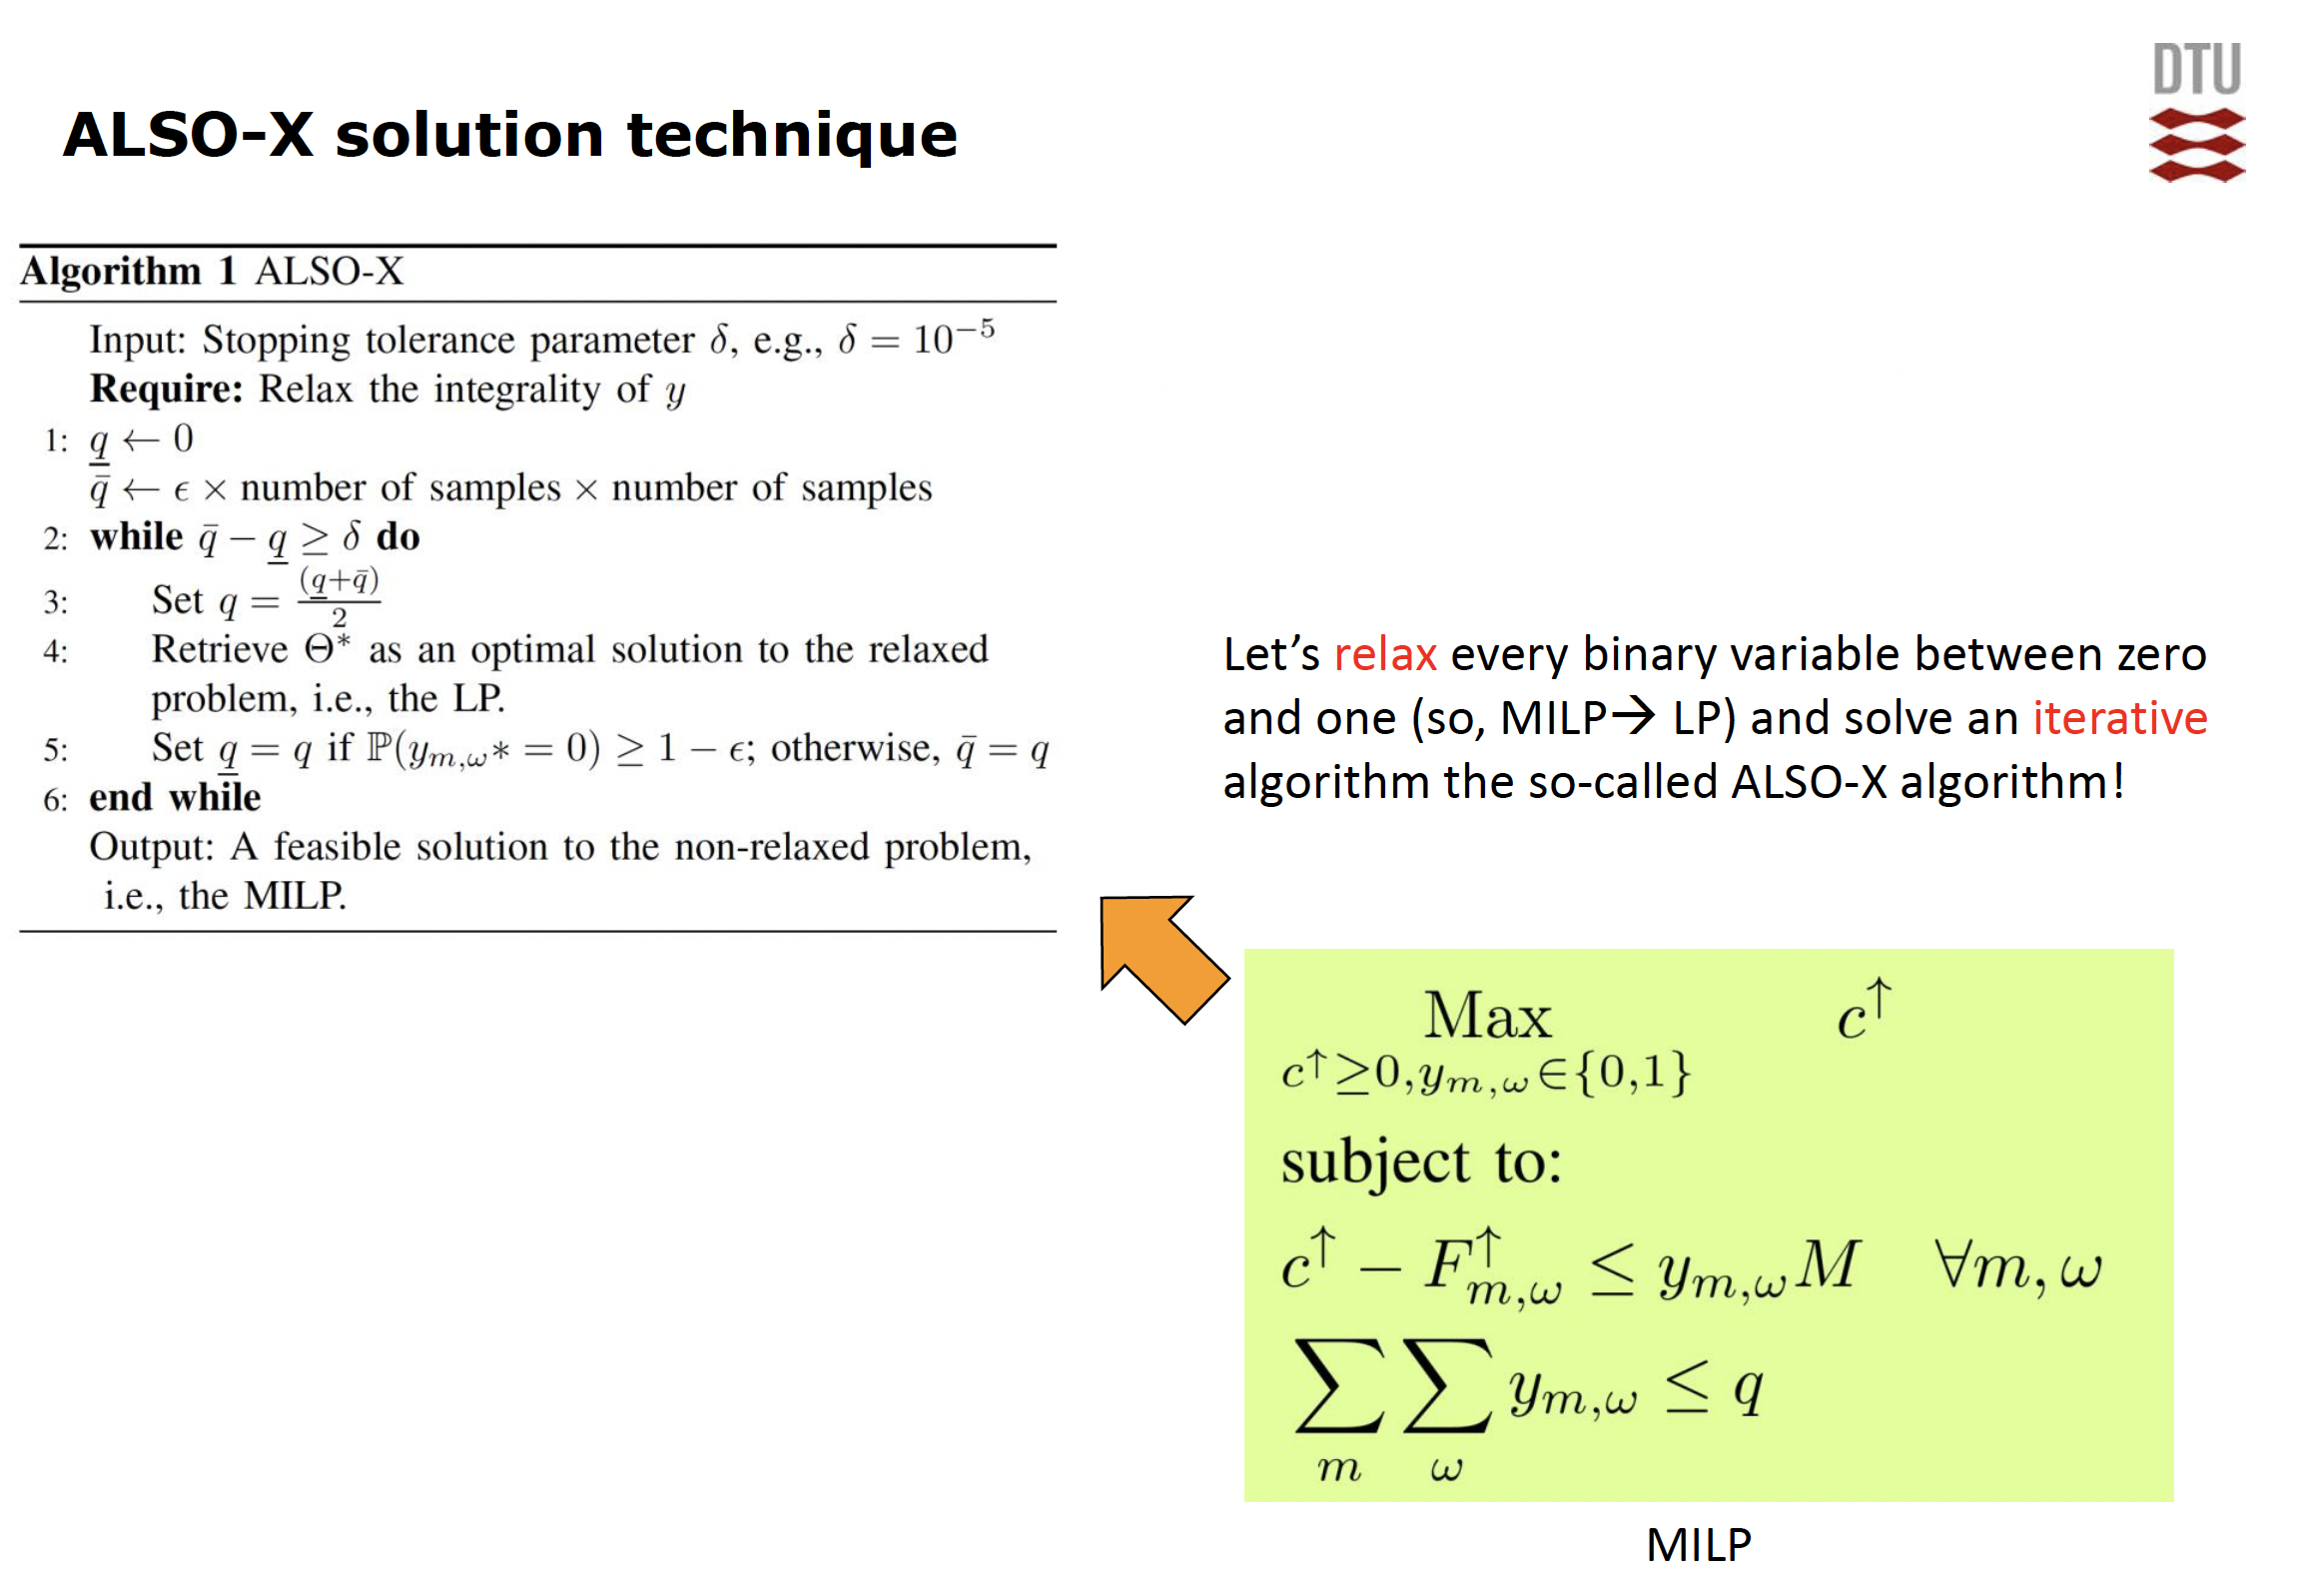

In [176]:
def run_also_x(in_sample_profiles,epsilon=0.1, return_lists=False):
    # Step 0: initialise model, add decision variable (reserve bid) and relax binary variable

    num_profiles, num_minutes = in_sample_profiles.shape
    loads_flat = in_sample_profiles.to_numpy().flatten()
    N = num_profiles * num_minutes
    iteration=0

    M = 1e4 # Big-M constant, "relaxes" the load constraint when slack y is active
    delta = 1e-5 # stopping tolerance for q

    start = time.time()

    ## Create Gurobi model
    m = Model()

    ## Decision variables
    r = m.addVar(lb=0,ub=600, name='reserve_bid')      # reserve bid (kW)
    y = m.addVars(N, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="violations")  # relaxed violation indicators

    ## Objective function
    m.setObjective(r, GRB.MAXIMIZE)

    ## Constraints for each minute
    for i in range(N):
        m.addConstr(loads_flat[i] + M * y[i] >= r, name=f"load_constraint_{i}")

    # Initial slack constraint (will be updated)
    violation_limit = epsilon * num_profiles * num_minutes
    slack_constr = m.addConstr(quicksum(y[i] for i in range(N)) <= violation_limit, name="slack_budget")

    best_r = 1000

    # Step 1: Initialize bisection bounds
    q_lower = 0
    q_upper = epsilon * num_profiles * num_minutes  # maximum allowed total violations

    # setup some lists to gain insight about the algorithm 
    r_dict = {}
    good_fraction_list = []
    q_mid_list = []
    q_upper_list = []
    q_lower_list = []

    # Step 2: Start iteration 
    while q_upper - q_lower >= delta:
        iteration += 1

        # Step 3: choosing midpoint - increase lower bound by half compared to upper bound
        # update rhs constraint to updated q value
        q_mid = (q_lower+q_upper)/2
        slack_constr.RHS = q_mid
        
        q_mid_list.append(q_mid)
        q_upper_list.append(q_upper)
        q_lower_list.append(q_lower)

        # Step 4: retrieve optimal solution to relaxed LP
        m.optimize()
        r_value = r.X
        y_values = np.array([y[i].X for i in range(num_profiles * num_minutes)])

        # Step 5: set lower bound = upper bound if probability function complies with the required P90
        good_minutes = np.sum(y_values <= 1e-5) # Count how many y are "almost zero" (numerical precision)
        good_fraction = good_minutes / (num_profiles * num_minutes)  # Calculate percentage
        good_fraction_list.append(good_fraction)

        if good_fraction >= (1 - epsilon): # solution feasible -> increase lower bound
            q_lower = q_mid  
            best_r = r.X  
            r_dict[iteration] = r.X 
        else:
            q_upper = q_mid  # keep lower bound, reduce upper bound
            print("else")

    modeltime = time.time() - start
    print('ALSO-X complete')
    print(f'Total time: {modeltime:.3f} s.')
    print(f'Number of iterations: {iteration}.')
    print(f'Optimal Reserve Bid (r*): {best_r:.5f} kW.')

    if return_lists:
        return best_r, q_mid_list, r_dict, good_fraction_list
    else:
        return best_r

r_alsox, q_mid_list, r_dict, good_fraction_list = run_also_x(in_sample_profiles, epsilon=0.1, return_lists=True)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6001 rows, 6001 columns and 18000 nonzeros
Model fingerprint: 0x00d0dca6
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+02]
  RHS range        [2e+02, 6e+02]
Presolve time: 0.00s
Presolved: 6001 rows, 6001 columns, 18000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0000000e+02   9.033322e+03   0.000000e+00      0s
    6000    6.0000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 6000 iterations and 0.02 seconds (0.02 work units)
Optimal objective  6.000000000e+02
else
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimi

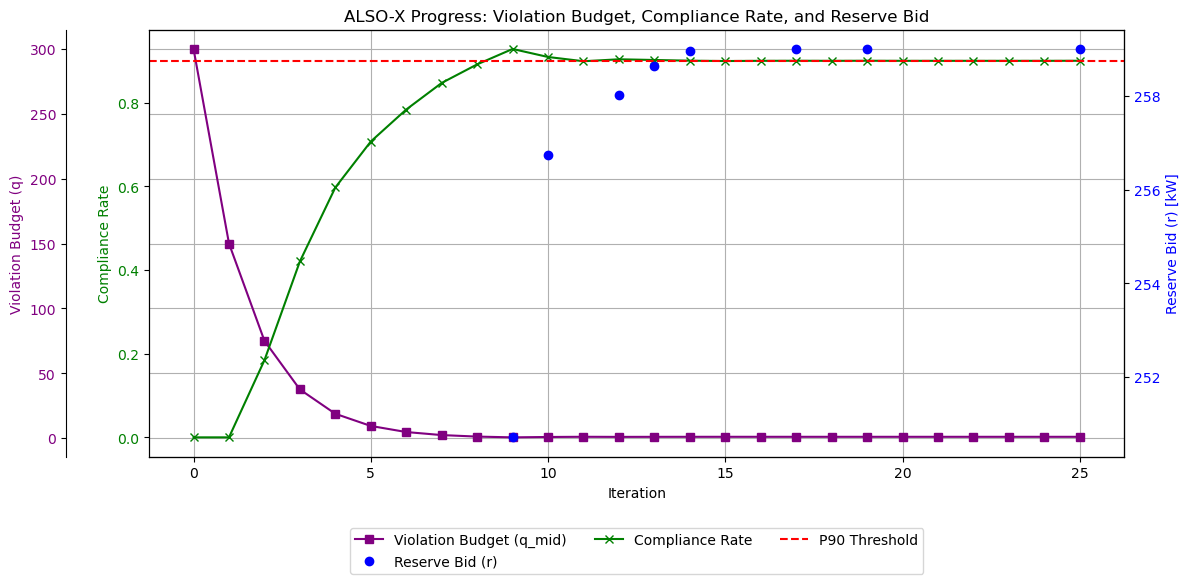

In [177]:
iterations = np.arange(len(q_mid_list))
r_iterations = list(r_dict.keys())
r_iterations = [i - 1 for i in r_iterations]
r_values = list(r_dict.values())

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary left y-axis: Violation budget
color_q = 'purple'
ax1.spines["left"].set_position(("outward", 60))
#ax1.semilogy()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Violation Budget (q)', color=color_q)
ax1.plot(iterations, q_mid_list, color=color_q, marker='s', linestyle='-', label='Violation Budget (q_mid)')
ax1.tick_params(axis='y', labelcolor=color_q)
ax1.grid(True)

# Secondary left y-axis (shifted outward)
ax3 = ax1.twinx()
#ax3.spines["left"].set_position(("outward", 60))  # <-- move it outward by 60 points
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()
ax3.set_ylabel('Compliance Rate', color='green')
ax3.plot(iterations, good_fraction_list, color='green', marker='x', linestyle='-', label='Compliance Rate')
ax3.axhline(y=0.9, color='red', linestyle='--', label='P90 Threshold')
ax3.tick_params(axis='y', labelcolor='green')

# Right y-axis: Reserve bid
ax2 = ax1.twinx()
color_r = 'blue'
ax2.set_ylabel('Reserve Bid (r) [kW]', color=color_r)
ax2.plot(r_iterations, r_values, color=color_r, marker='o', linestyle='None', label='Reserve Bid (r)')
ax2.tick_params(axis='y', labelcolor=color_r)

# Combine legends properly
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2, ax3]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Title
plt.title('ALSO-X Progress: Violation Budget, Compliance Rate, and Reserve Bid')

plt.tight_layout()
plt.show()

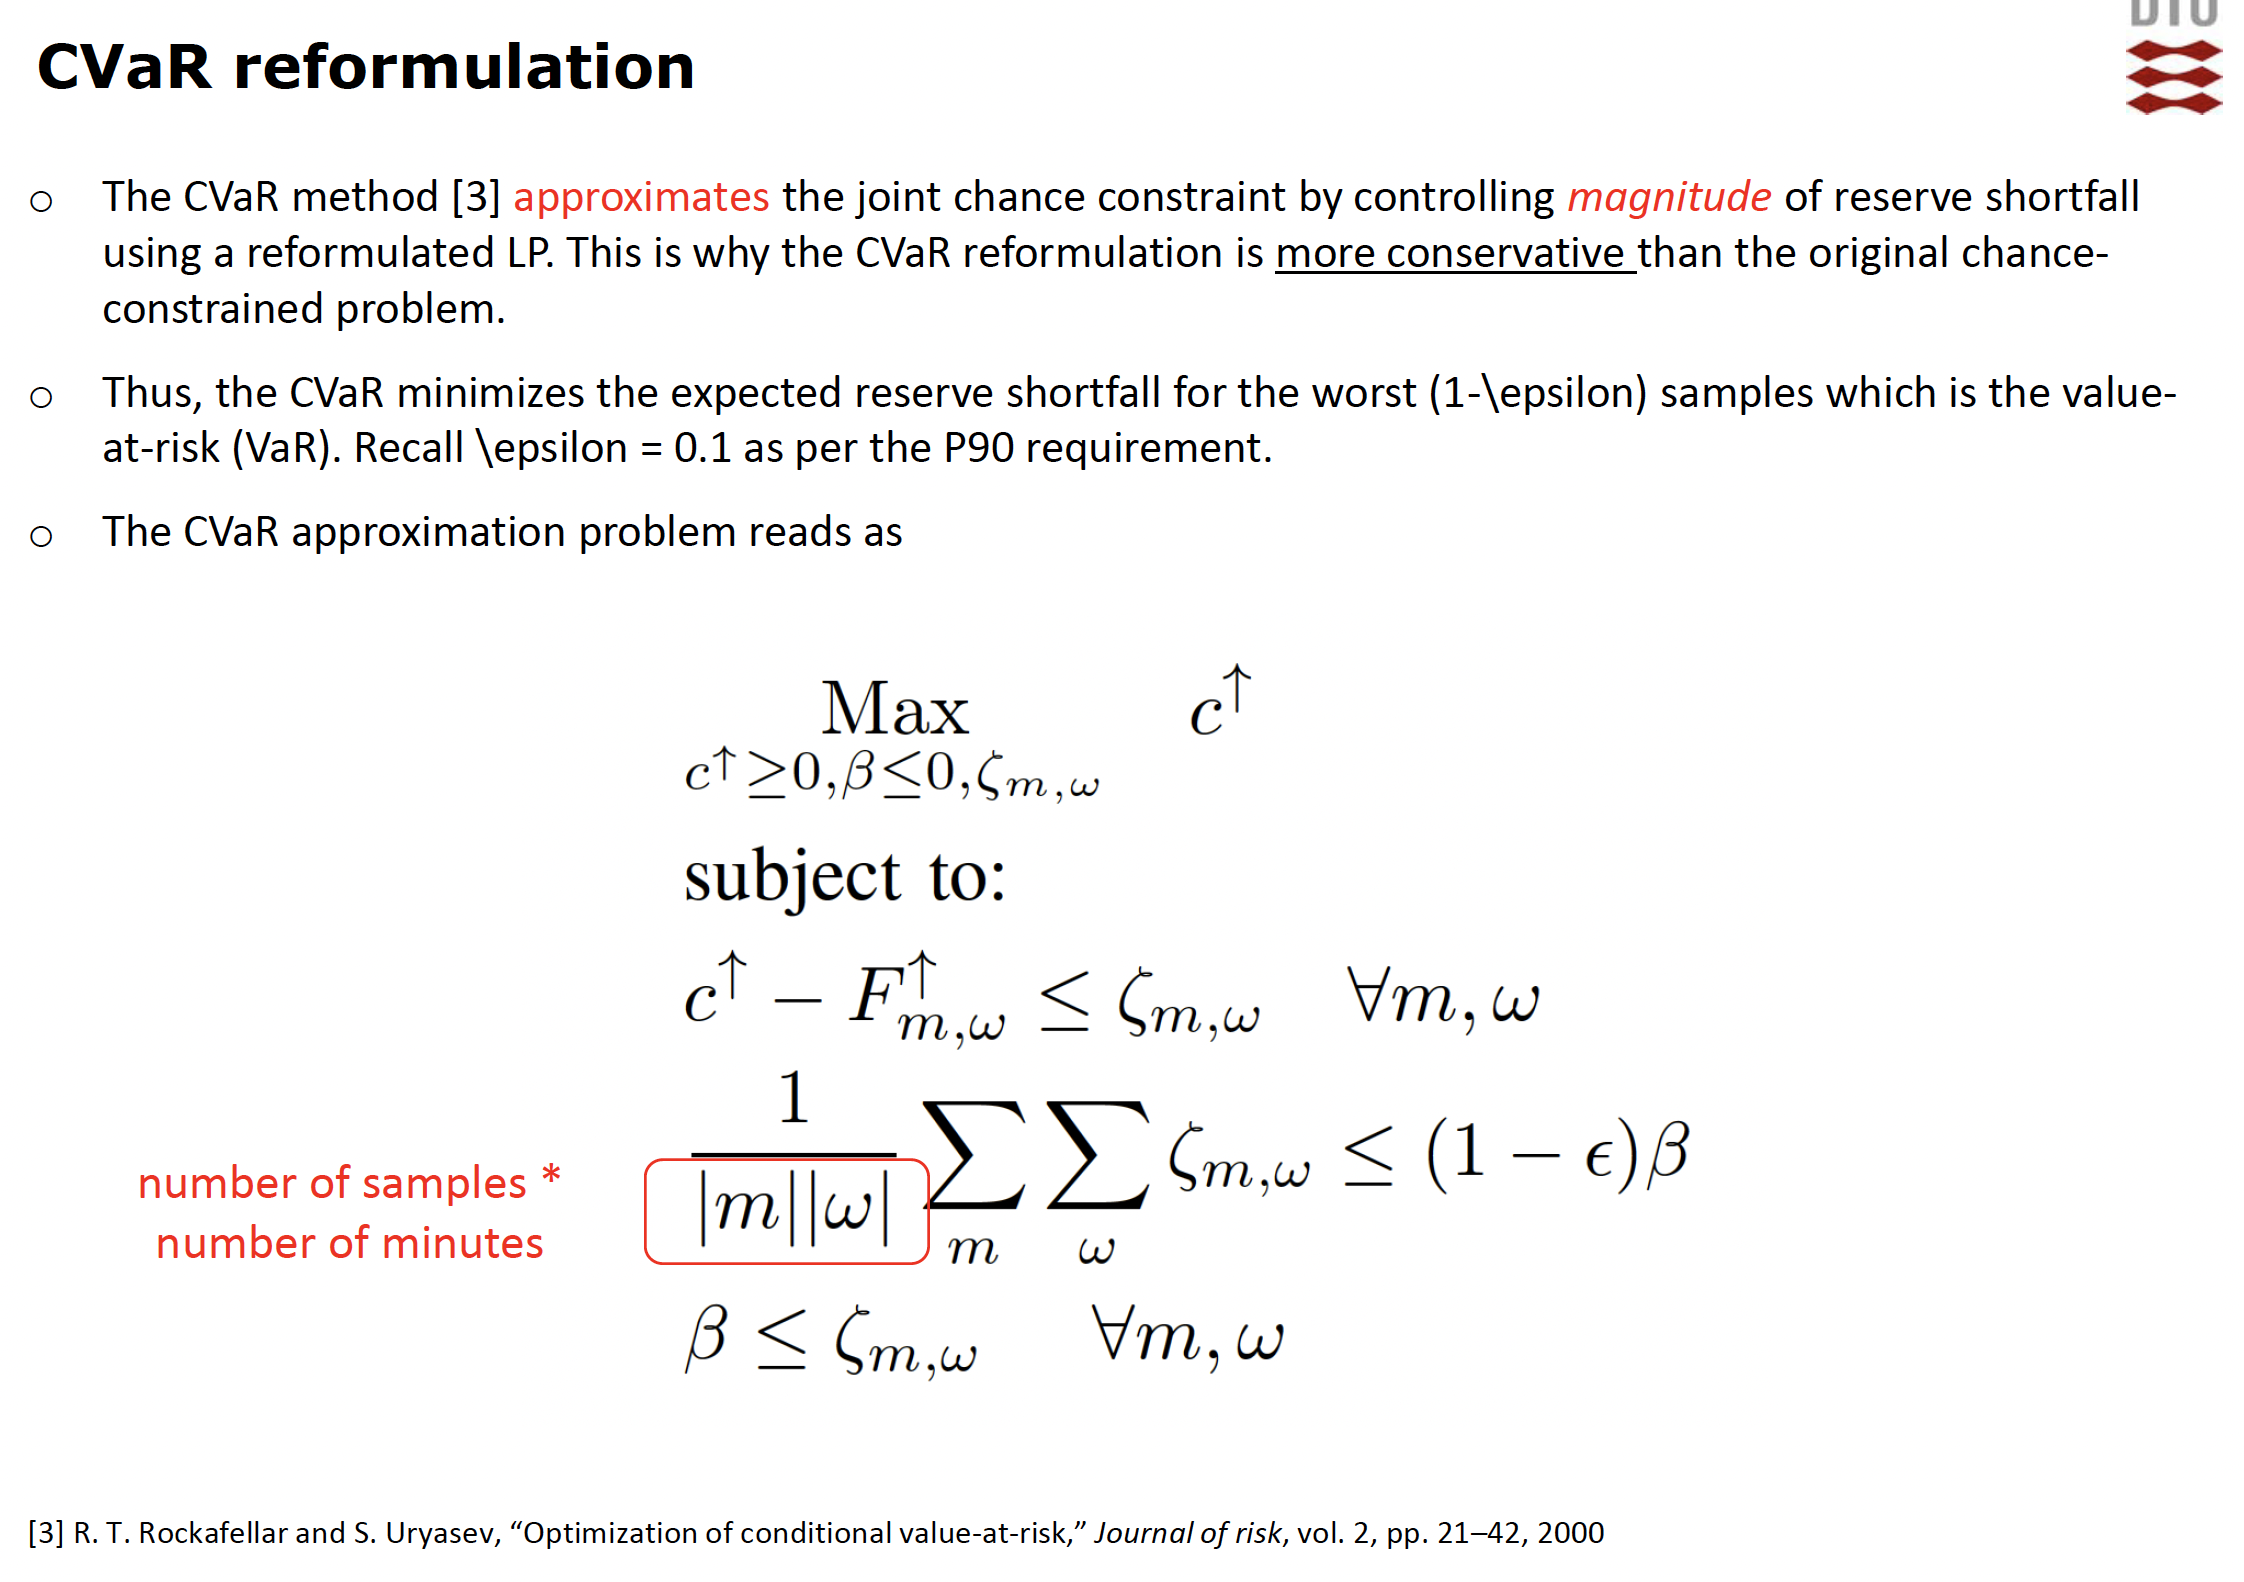

In [ ]:
def solve_cvar_reserve_bid(load_profiles, epsilon=0.10):
    """
    Solves the CVaR-based reserve bid optimization.

    Args:
    - load_profiles: np.array or pd.DataFrame of shape (num_profiles, num_minutes)
    - epsilon: allowable violation probability (default 10% for P90)

    Returns:
    - optimal_r: optimal reserve bid found
    """

    # Step 1: Prepare data
    if not isinstance(load_profiles, np.ndarray):
        load_profiles = load_profiles.to_numpy()
    
    num_profiles, num_minutes = load_profiles.shape
    N = num_profiles * num_minutes
    loads_flat = load_profiles.flatten()

    # Step 2: Create model
    m = Model("CVaR_Reserve_Bid")
    m.setParam('OutputFlag', 0)  # Silent mode

    # Decision variables
    r = m.addVar(lb=0, name='reserve_bid')  # reserve bid c↑
    beta = m.addVar(ub=0, name='beta')       # beta <= 0
    zeta = m.addVars(N, lb=0, name='zeta')   # slack variables

    # Step 3: Objective function
    m.setObjective(r, GRB.MAXIMIZE)

    # Step 4: Constraints
    # For each minute-sample: c↑ - F_mw <= ζ_mw
    for i in range(N):
        m.addConstr(r - loads_flat[i] <= zeta[i], name=f"shortfall_constraint_{i}")

    # Average shortfall constraint
    m.addConstr((1 / N) * quicksum(zeta[i] for i in range(N)) <= (1 - epsilon) * beta, name="average_shortfall")

    # β <= ζ_mw for all samples
    for i in range(N):
        m.addConstr(beta <= zeta[i], name=f"beta_upper_bound_{i}")

    # Step 5: Solve
    m.optimize()

    if m.status == GRB.OPTIMAL:
        optimal_r = r.X
        print(f"✅ Optimal Reserve Bid (CVaR) found: {optimal_r:.5f} kW")
        return optimal_r
    else:
        print("❌ Optimization did not converge to an optimal solution.")
        return None

solve_cvar_reserve_bid(in_sample_profiles_np)

✅ Optimal Reserve Bid (CVaR) found: 220.04000 kW


220.04

In [127]:
quicksum(zeta[i] for i in range(N))

<gurobi.LinExpr: zeta[0] + zeta[1] + zeta[2] + zeta[3] + zeta[4] + zeta[5] + zeta[6] + zeta[7] + zeta[8] + zeta[9] + zeta[10] + zeta[11] + zeta[12] + zeta[13] + zeta[14] + zeta[15] + zeta[16] + zeta[17] + zeta[18] + zeta[19] + zeta[20] + zeta[21] + zeta[22] + zeta[23] + zeta[24] + zeta[25] + zeta[26] + zeta[27] + zeta[28] + zeta[29] + zeta[30] + zeta[31] + zeta[32] + zeta[33] + zeta[34] + zeta[35] + zeta[36] + zeta[37] + zeta[38] + zeta[39] + zeta[40] + zeta[41] + zeta[42] + zeta[43] + zeta[44] + zeta[45] + zeta[46] + zeta[47] + zeta[48] + zeta[49] + zeta[50] + zeta[51] + zeta[52] + zeta[53] + zeta[54] + zeta[55] + zeta[56] + zeta[57] + zeta[58] + zeta[59] + zeta[60] + zeta[61] + zeta[62] + zeta[63] + zeta[64] + zeta[65] + zeta[66] + zeta[67] + zeta[68] + zeta[69] + zeta[70] + zeta[71] + zeta[72] + zeta[73] + zeta[74] + zeta[75] + zeta[76] + zeta[77] + zeta[78] + zeta[79] + zeta[80] + zeta[81] + zeta[82] + zeta[83] + zeta[84] + zeta[85] + zeta[86] + zeta[87] + zeta[88] + zeta[89] + zet

In [144]:
# Step 0: Load data
num_profiles, num_minutes = in_sample_profiles.shape
N = num_profiles * num_minutes
epsilon = 0.9

loads_flat = in_sample_profiles.to_numpy().flatten()  # flatten to a 1D array

# Step 1: Create Gurobi model
m = Model("CVaR_Reserve_Bid")
m.setParam('OutputFlag', 0)  

# Decision variables
r = m.addVar(lb=0, name='reserve_bid')  # reserve bid r >= 0
beta = m.addVar(ub=0, name='beta')       # beta <= 0
zeta = m.addVars(N, name='zeta')   # slack variables ζ_i >= 0

# Objective function: maximize reserve bid r
m.setObjective(r, GRB.MAXIMIZE)

# add slack definition contraint
for i in range(N):
    m.addConstr(r - loads_flat[i] <= zeta[i], name=f"shortfall_constraint_{i}")

# add average shortfall constraint
m.addConstr((1 / N) * quicksum(zeta[i] for i in range(N)) <= (1 - epsilon) * beta, name="average_shortfall")
# add beta upper bound constraint
for i in range(N):
    m.addConstr(beta <= zeta[i], name=f"beta_upper_bound_{i}")

m.optimize()

if m.status == GRB.OPTIMAL:
    optimal_r = r.X
    print(f"Optimal Reserve Bid (CVaR) found: {optimal_r:.5f} kW")
else:
    print("Optimization did not converge to an optimal solution.")
    optimal_r = None

Optimal Reserve Bid (CVaR) found: 220.04000 kW


### 2.2 Verification of the P90 Requirement Using Out-of-Sample Analysis: 
Using the 200 testing profiles, verify whether the P90 requirement is satisfied for both solution techniques
used. This step does not require solving any optimization problem. Instead, compare
the optimal reserve bid obtained in Step 2.1 with the actual power consumption under each
testing profile. For example, if the stochastic load bids 300 kW to the FCR-D UP market
for a given hour, and its consumption at a certain minute within that hour is 270 kW, this
would indicate a reserve shortfall of 30 kW for that minute

In [ ]:
print("Bid ALSO-X: ", r_alsox)

# calculate when we violate/offer more than we can bid

# Containers to store per-profile results
num_minutes_below_r = []   # how many minutes load < r
margins_below_r = []       # list of lists: margin = r - load, only where load < r

# Loop through each profile
for idx, row in out_of_sample_profiles.iterrows():
    load_profile = row.values                  # shape (60,)
    below_mask = load_profile < r_alsox    # Boolean mask
    count_below = np.sum(below_mask)           # Number of minutes load < r
    margins = r_alsox - load_profile[below_mask]  # Only where below
    
    num_minutes_below_r.append(count_below)
    margins_below_r.append(margins)  # Note: this is an array of length count_below

# Convert to numpy array for analysis if needed
num_minutes_below_r = np.array(num_minutes_below_r)

print("Profile 0: Minutes below bid =", num_minutes_below_r[0])
print("Profile 0: Margins below bid =", margins_below_r[0])

Bid ALSO-X:  258.9999760805289
Profile 0: Minutes below bid = 15
Profile 0: Margins below bid = [16.81997608  4.25997608 27.10997608 35.94997608  2.88997608  8.29997608
  6.46997608 36.67997608  5.05997608 21.15997608  3.98997608 17.16997608
  9.43997608  3.69997608 25.75997608]


In [157]:
num_minutes_below_r

array([15,  3,  0,  0,  0,  0, 20,  0,  0, 41,  0,  0, 23, 20, 10,  0,  6,
        0,  0,  0,  0,  0,  0, 26,  0, 11,  0, 17, 15,  0,  4,  0,  0,  0,
        0, 20,  1,  0,  5, 14,  0,  1,  2,  7,  0,  8,  0, 15, 11,  0,  0,
        0,  3,  0,  0,  0,  0,  6,  0,  0,  0,  0, 34,  0,  0,  9,  0,  0,
        0, 24,  0,  0,  3, 31,  9, 19,  0,  0,  0, 20, 28,  0,  5,  0,  0,
       14,  0,  3,  0, 20,  0,  0,  0,  0, 22,  0,  0,  0,  0,  1,  8, 22,
       25, 19,  4,  0,  0,  3,  2,  8,  0,  0,  0,  0,  3,  0,  0,  0,  0,
        0,  5, 15,  0,  6, 10, 25,  0,  9,  3,  0,  0, 10,  7,  0,  0,  0,
        0,  6,  0,  0,  0,  0, 20,  0,  4,  7,  0, 33,  1,  0,  0,  0, 21,
        8,  0,  0,  0,  0,  0,  0,  4,  0, 39,  0, 17,  0,  0,  0,  0,  1,
        0, 10,  9, 36, 10, 21,  0,  0,  0,  0,  0,  0, 14,  0,  2,  0,  0,
        0,  0,  0,  0,  2,  0, 15,  0, 10,  0,  0,  0,  0])

In [ ]:
unique_vals, counts = np.unique(num_minutes_below_r, return_counts=True)

df_overbid_freq = pd.DataFrame({
    "overbid_minutes": unique_vals,
    "profile_count": counts
})

df_overbid_freq = df_overbid_freq.sort_values("overbid_minutes").reset_index(drop=True)
df_overbid_freq["Frequency of overbid"] = df_overbid_freq["overbid_minutes"]/60*100

df_overbid_freq.head()

overbid_minutes  profile_count  Frequency of overbid
0                0            120              0.000000
1                1              5              1.666667
2                2              4              3.333333
3                3              7              5.000000
4                4              4              6.666667

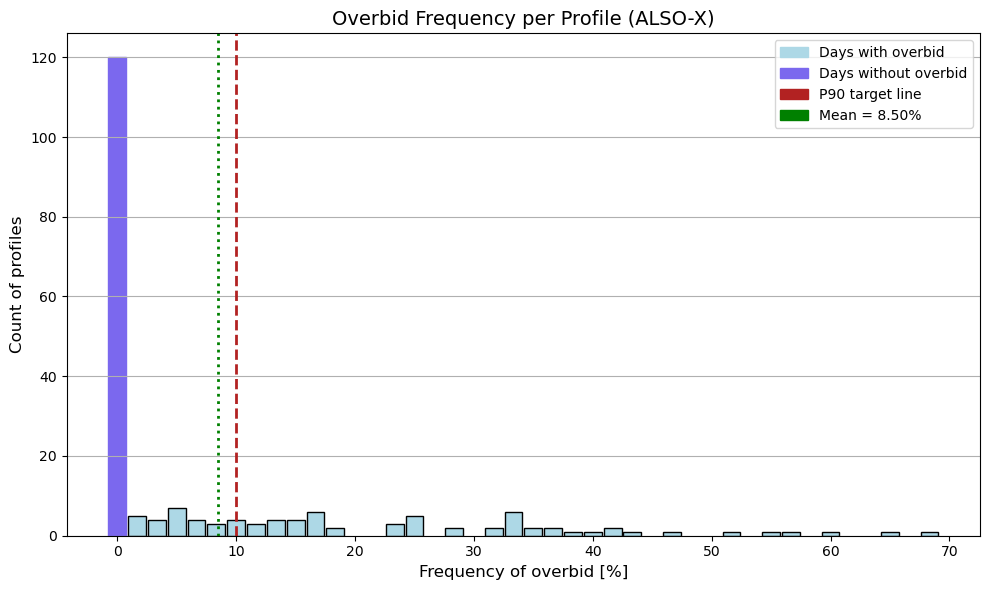

In [ ]:
mean_freq = (
    (df_overbid_freq["Frequency of overbid"] * df_overbid_freq["profile_count"]).sum()
    / df_overbid_freq["profile_count"].sum()
)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(
    df_overbid_freq["Frequency of overbid"],
    df_overbid_freq["profile_count"],
    width=1.5,
    color='lightblue',
    edgecolor='black'
)

# Highlight 0% overbid bar 
zero_index = df_overbid_freq["Frequency of overbid"] == 0
bars[zero_index.idxmax()].set_color('mediumslateblue')

# Add vertical lines 
ax.axvline(10, color='firebrick', linestyle='--', linewidth=2)
ax.axvline(mean_freq, color='green', linestyle=':', linewidth=2)

# Labels and formatting
ax.set_xlabel("Frequency of overbid [%]", fontsize=12)
ax.set_ylabel("Count of profiles", fontsize=12)
ax.set_title("Overbid Frequency per Profile (ALSO-X)", fontsize=14)
ax.grid(axis='y')

legend_elements = [
    mpatches.Patch(color='lightblue', label='Days with overbid'),
    mpatches.Patch(color='mediumslateblue', label='Days without overbid'),
    mpatches.Patch(color='firebrick', label='P90 target line'),
    mpatches.Patch(color='green', label=f'Mean = {mean_freq:.2f}%')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


### 2.3 Energinet Perspective: 
Take the perspective of Energinet and investigate how varying the P90 requirement 
(e.g., by adjusting the allowed frequency of reserve shortfall between
80% and 100%) impacts the optimal reserve bid (in-sample analysis using ALSO-X) and the
expected reserve shortfall (out-of-sample analysis). Analyze whether there is an observable
trade-off between these two factors as the P90 requirement is relaxed or tightened.

In [194]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 , 1]
rs_alsox = []

for epsilon in epsilons:
    r_alsox = run_also_x(in_sample_profiles, epsilon)
    rs_alsox.append(r_alsox)

ALSO-X complete
Total time: 0.105 s.
Number of iterations: 0.
Optimal Reserve Bid (r*): 1000.00000 kW.
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6001 rows, 6001 columns and 18000 nonzeros
Model fingerprint: 0xa631253c
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+02]
  RHS range        [3e+01, 6e+02]
Presolve time: 0.00s
Presolved: 6001 rows, 6001 columns, 18000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0000000e+02   9.033322e+03   0.000000e+00      0s
    3142    4.1378993e+02   0.000000e+00   0.000000e+00      0s

Solved in 3142 iterations and 0.40 seconds (2.19 work units)
Optimal objective  4.137899290e+02
else
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU 

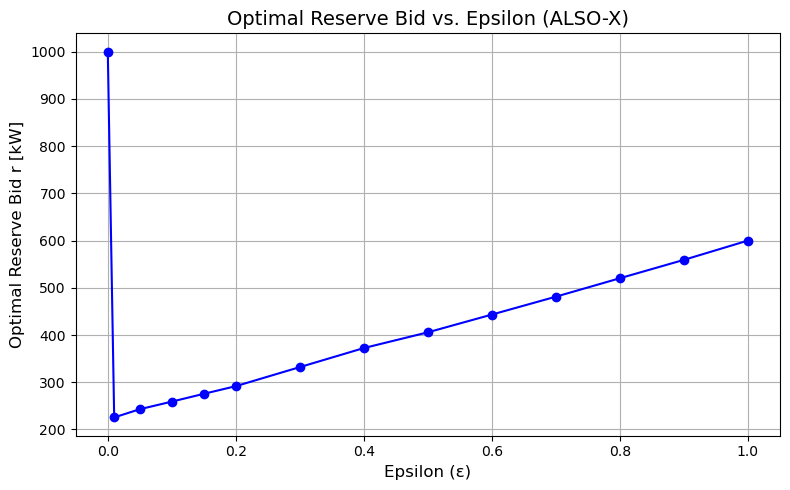

In [195]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(epsilons, rs_alsox, marker='o', linestyle='-', color='blue')

ax.set_xlabel('Epsilon (ε)', fontsize=12)
ax.set_ylabel('Optimal Reserve Bid r [kW]', fontsize=12)
ax.set_title('Optimal Reserve Bid vs. Epsilon (ALSO-X)', fontsize=14)
ax.grid(True)

# Optional: If you want to reverse the x-axis (if decreasing epsilon should go left → right)
# ax.invert_xaxis()

plt.tight_layout()
plt.show()


In [196]:
expected_shortfalls = []

# out_of_sample_profiles: DataFrame shape (200, 60)
loads_flat_test = out_of_sample_profiles.to_numpy().flatten()
total_minutes = loads_flat_test.shape[0]

for r_opt in rs_alsox:
    # Shortfall = when bid exceeds actual load
    shortfalls = np.maximum(0, r_opt - loads_flat_test)
    expected_shortfall = np.mean(shortfalls)  # Average over all minutes
    expected_shortfalls.append(expected_shortfall)


In [198]:
r_opt - loads_flat_test

array([237.67475484, 206.12      , 189.88      , ..., 215.63      ,
       202.19      , 179.68      ])

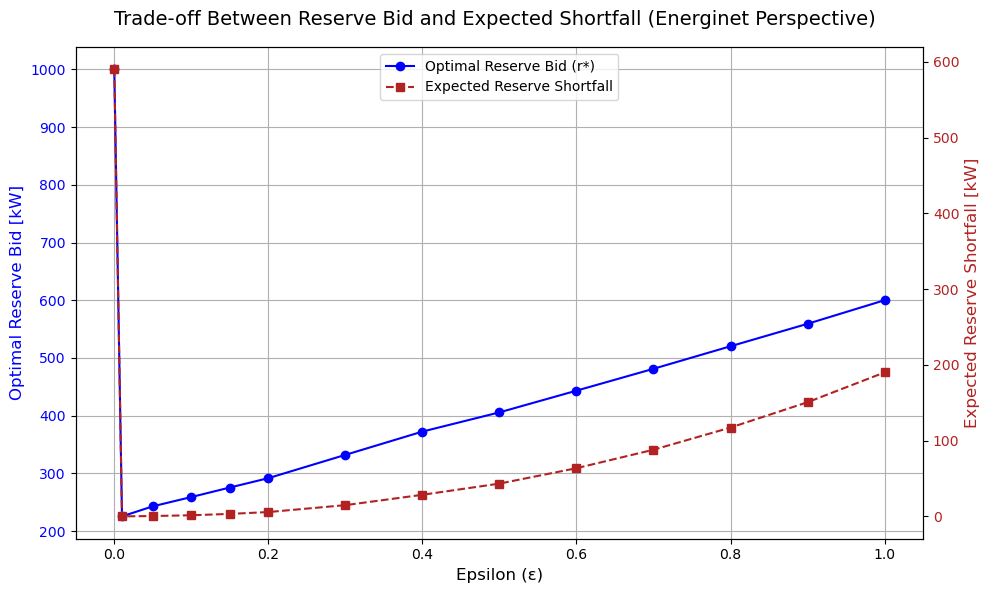

In [197]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Reserve bid on left y-axis
ax1.plot(epsilons, rs_alsox, 'o-', color='blue', label='Optimal Reserve Bid (r*)')
ax1.set_xlabel('Epsilon (ε)', fontsize=12)
ax1.set_ylabel('Optimal Reserve Bid [kW]', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Expected shortfall on right y-axis
ax2 = ax1.twinx()
ax2.plot(epsilons, expected_shortfalls, 's--', color='firebrick', label='Expected Reserve Shortfall')
ax2.set_ylabel('Expected Reserve Shortfall [kW]', color='firebrick', fontsize=12)
ax2.tick_params(axis='y', labelcolor='firebrick')

# Titles and grid
fig.suptitle('Trade-off Between Reserve Bid and Expected Shortfall (Energinet Perspective)', fontsize=14)
ax1.grid(True)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.show()


In [ ]:
overbid_mean_frequencies = []

num_profiles, num_minutes = out_of_sample_profiles.shape
minutes_per_profile = num_minutes

for r_opt in rs_alsox:
    num_minutes_below_r = []
    
    # Step 1: For each profile
    for idx, row in out_of_sample_profiles.iterrows():
        load_profile = row.values
        below_mask = load_profile < r_opt
        count_below = np.sum(below_mask)
        num_minutes_below_r.append(count_below)
    
    num_minutes_below_r = np.array(num_minutes_below_r)
    
    # Step 2: Build frequency table
    unique_vals, counts = np.unique(num_minutes_below_r, return_counts=True)
    df_overbid_freq = pd.DataFrame({
        "overbid_minutes": minutes_per_profile - unique_vals,  # overbid = 60 - below
        "profile_count": counts
    })
    
    # Calculate frequency of overbid per profile
    df_overbid_freq["Frequency of overbid"] = df_overbid_freq["overbid_minutes"] / 60 * 100
    
    # Step 3: Calculate weighted mean overbid frequency
    weighted_mean_freq = (
        (df_overbid_freq["Frequency of overbid"] * df_overbid_freq["profile_count"]).sum()
        / df_overbid_freq["profile_count"].sum()
    )
    
    overbid_mean_frequencies.append(weighted_mean_freq)

In [214]:
overbid_mean_frequencies = []
for r_opt in rs_alsox:
    num_minutes_below_r = []   # how many minutes load < r
    margins_below_r = []       # list of lists: margin = r - load, only where load < r

    # Loop through each profile
    for idx, row in out_of_sample_profiles.iterrows():
        load_profile = row.values                  # shape (60,)
        below_mask = load_profile < r_alsox    # Boolean mask
        count_below = np.sum(below_mask)           # Number of minutes load < r
        margins = r_alsox - load_profile[below_mask]  # Only where below
        
        num_minutes_below_r.append(count_below)
        margins_below_r.append(margins)  # Note: this is an array of length count_below

    # Convert to numpy array for analysis if needed
    num_minutes_below_r = np.array(num_minutes_below_r)
    unique_vals, counts = np.unique(num_minutes_below_r, return_counts=True)

    df_overbid_freq = pd.DataFrame({
        "overbid_minutes": unique_vals,
        "profile_count": counts
    })

    df_overbid_freq = df_overbid_freq.sort_values("overbid_minutes").reset_index(drop=True)
    df_overbid_freq["Frequency of overbid"] = df_overbid_freq["overbid_minutes"]/60*100

    df_overbid_freq.head()
    mean_freq = (
        (df_overbid_freq["Frequency of overbid"] * df_overbid_freq["profile_count"]).sum()
        / df_overbid_freq["profile_count"].sum()
    )
    overbid_mean_frequencies.append(mean_freq)


In [215]:
overbid_mean_frequencies

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [207]:
overbid_mean_frequencies

[0.0,
 99.08333333333334,
 95.63333333333333,
 91.49999999999999,
 86.93333333333334,
 82.775,
 71.91666666666669,
 60.37500000000001,
 50.9,
 40.766666666666666,
 30.575,
 19.6,
 8.558333333333332,
 0.0]

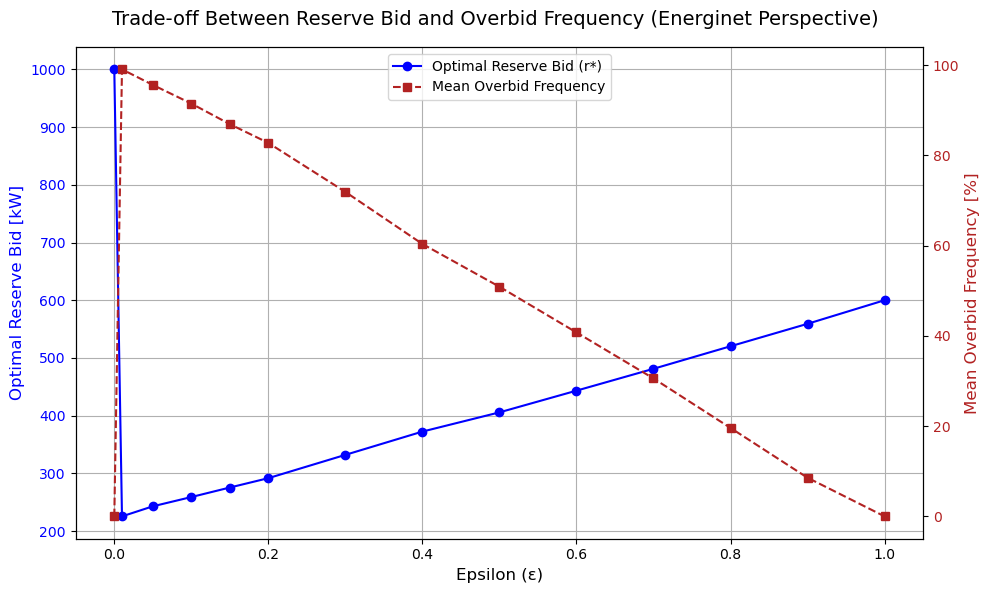

In [204]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Reserve bid on left y-axis
ax1.plot(epsilons, rs_alsox, 'o-', color='blue', label='Optimal Reserve Bid (r*)')
ax1.set_xlabel('Epsilon (ε)', fontsize=12)
ax1.set_ylabel('Optimal Reserve Bid [kW]', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Mean overbid frequency on right y-axis
ax2 = ax1.twinx()
ax2.plot(epsilons, overbid_mean_frequencies, 's--', color='firebrick', label='Mean Overbid Frequency')
ax2.set_ylabel('Mean Overbid Frequency [%]', color='firebrick', fontsize=12)
ax2.tick_params(axis='y', labelcolor='firebrick')

# Titles and grid
fig.suptitle('Trade-off Between Reserve Bid and Overbid Frequency (Energinet Perspective)', fontsize=14)
ax1.grid(True)

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.show()
